# Midterm Project

## Problem 1: Speed and Stopping Distances of Cars

Import data from "cars.csv".

In [1]:
cars.data = read.csv('cars.csv')

### 1. Use leave-one-out cross validation, and plot the CV errors versus degree of polynomial. 
Report your finding and conclusion.

In [29]:
library(boot)

In [8]:
cars.loocv.error=rep(0,10)

for(i in 1:10){
    glm.fit=glm(dist~poly(speed,i),data=cars.data)
    cars.loocv.error[i]=cv.glm(cars.data,glm.fit)$delta[1]
}
cars.loocv.error

[1] 246.4054 243.0292 246.8288 250.0914 279.6864 327.5014 408.9479 476.4366
 [9] 318.1917 696.9015

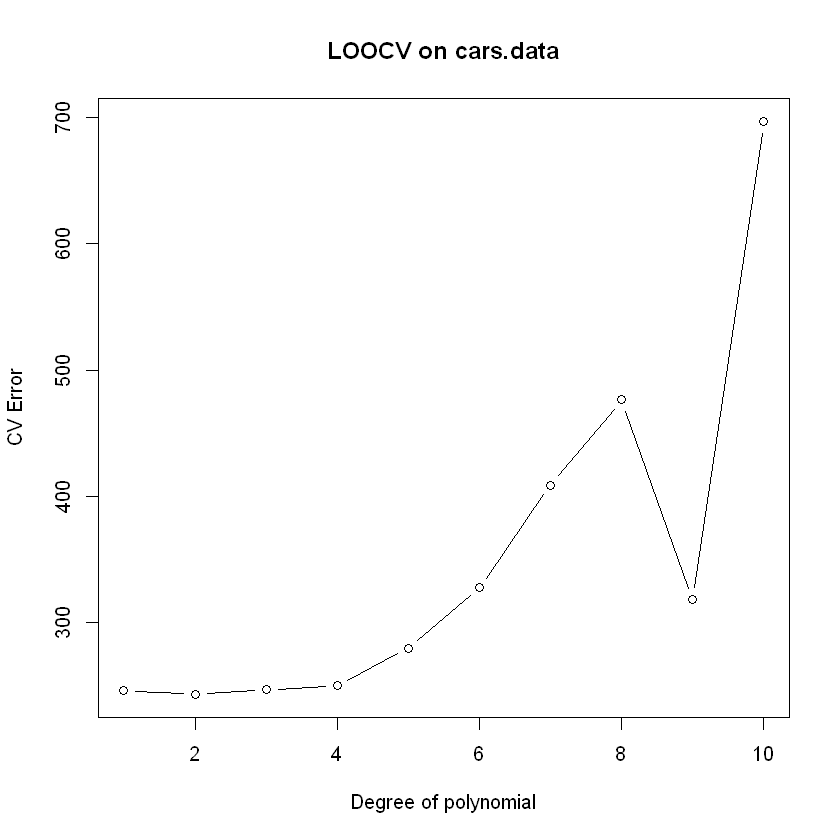

In [9]:
plot(1:10,cars.loocv.error,type='b',xlab="Degree of polynomial",ylab="CV Error",main="LOOCV on cars.data")

From this plot, we can find the CV Error of degree = 2 is the smallest one, so the Quadratic model(dist~speed+speed^2) is the best model for this problem.

### 2. Use 5-fold cross validation, and plot the CV errors versus degree of polynomial. 
Report your finding and conclusion.

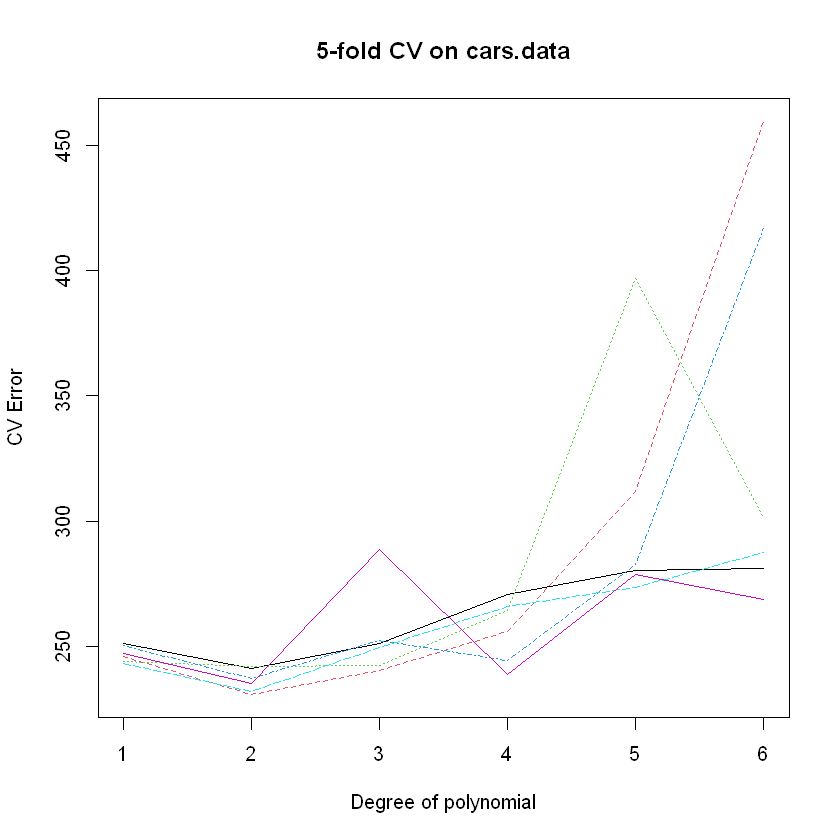

In [26]:
K=5
deg.max = 6
time.max = 6

cars.cv.error.6=matrix(rep(0,deg.max*time.max),deg.max,time.max)
for(j in 1:time.max){
    set.seed(j+114)
    for(i in 1:deg.max){
        glm.fit=glm(dist~poly(speed,i),data=cars.data)
        cars.cv.error.6[i,j]=cv.glm(cars.data,glm.fit,K=K)$delta[1]
    }
}
matplot(cars.cv.error.6,type='l',col=1:time.max ,xlab="Degree of polynomial",ylab="CV Error",main="5-fold CV on cars.data")

From this plot, we can find the CV Error of degree = 2 is the smallest one, so the Quadratic model(dist~speed+speed^2) is the best model for this problem.

### 3. Compare the above two approaches and report your findings.

For this given dataset, two approaches give the same final choice of model——the Quadratic model(dist~speed+speed^2). Since K-fold cross vaildation rely on random dataset split, so the randomness will affect its result, so we have to split dataset multiple times to overcome its unstability, while this unstability also reflect the data balance on the real data distribution.

## Problem 2: Titanic – Survival or Not

Import data from "titanic.csv".

Preprocess it with:

1. Omit NA sample
2. Create feature sex.male from Sex
3. Create feature pclass.1st,pclass.2nd,pclass.3rd from pclass

In [76]:
titanic.data=na.omit(read.csv("titanic.csv"))
titanic.data$sex.male=as.numeric(titanic.data$Sex=="male")
titanic.data$pclass.1st=as.numeric(titanic.data$Pclass==1)
titanic.data$pclass.2nd=as.numeric(titanic.data$Pclass==2)
titanic.data$pclass.3rd=as.numeric(titanic.data$Pclass==3)

### 1. Treat survival as response, fit a logistic regression model using predictors pclass, sex, age, sibsp and fare.
Report the estimated coefficients for Sex/male and pclass/3rd, and report their 95% confidence intervals.


Since pclass.1st, pclass.2nd and pclass.3rd are linear dependent(pclass.2nd=1-pclass.1st-pclass.3rd), in this report we just use the feature pclass.1st and pclass.3rd to represent the PClass.

In [66]:
library(ROCR);

titanic.logmod = glm(Survived~sex.male+pclass.1st+pclass.3rd+Age+SibSp+Fare,family="binomial",data=titanic.data)

summary(titanic.logmod)


Call:
glm(formula = Survived ~ sex.male + pclass.1st + pclass.3rd + 
    Age + SibSp + Fare, family = "binomial", data = titanic.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8192  -0.6436  -0.3845   0.6282   2.4471  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.863316   0.365804   7.827 4.98e-15 ***
sex.male    -2.616107   0.215413 -12.145  < 2e-16 ***
pclass.1st   1.308268   0.319741   4.092 4.28e-05 ***
pclass.3rd  -1.217522   0.246563  -4.938 7.89e-07 ***
Age         -0.044147   0.008262  -5.343 9.13e-08 ***
SibSp       -0.393449   0.123221  -3.193  0.00141 ** 
Fare         0.001750   0.002455   0.713  0.47599    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 964.52  on 713  degrees of freedom
Residual deviance: 636.03  on 707  degrees of freedom
AIC: 650.03

Number of Fisher Scoring iterations: 5


From the model summary, we can see Survived and sex.male is negative correlated, which proves that the gentleman on the Titanic indeed let lady go first. And Survived and pclass is positve correlated, so the passenagers with higher class have greater surviving probability than lower class. And Survived and Age is negative correlated, so it seems younger people have greater surviving probabiliry than older. Meanwhile Survived and SibSp is negative correlated, so it seems people who have less siblings/spouses aboard have greater surviving probabiliry than other since they don't have to take care of their familiy.

In [32]:
confint(titanic.logmod,c("sex.male","pclass.3rd"),level=0.95)

Waiting for profiling to be done...



,2.5 %,97.5 %
sex.male,-3.048940,-2.2032872
pclass.3rd,-1.705975,-0.7378443


### 2. Now, apply Bootstrap with 1000 repetitions to obtain the 95% confidence intervals for the above coefficients.
How do they compare with the reported confidence intervals from above.

In [89]:
titanic.logmod.fn=function(data,index){
    return(coef(glm(Survived~sex.male+pclass.1st+pclass.3rd+Age+SibSp+Fare,family="binomial",data=data,subset=index)))
}

In [95]:
set.seed(114514)
titanic.logmod.boot<-boot(titanic.data,titanic.logmod.fn,1000)
titanic.logmod.boot.sex.male=titanic.logmod.boot$t[,2]
titanic.logmod.boot.pclass.3rd=titanic.logmod.boot$t[,4]

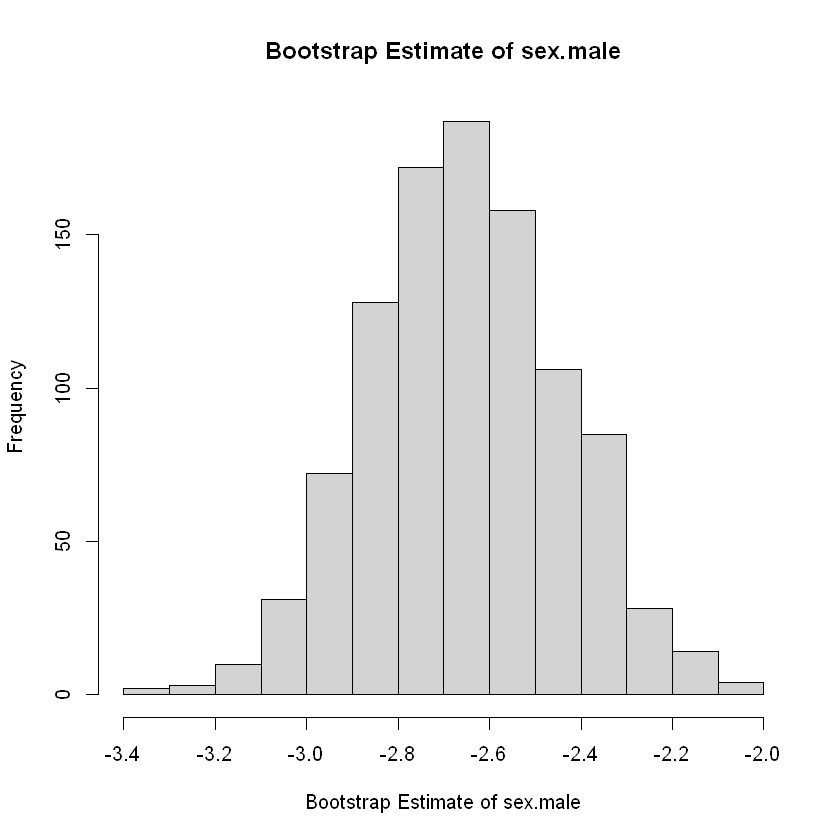

In [96]:
hist(titanic.logmod.boot.sex.male,xlab="Bootstrap Estimate of sex.male",main="Bootstrap Estimate of sex.male")

In [98]:
quantile(titanic.logmod.boot.sex.male,probs=seq(0.025,0.975,0.95))

2.5%     97.5% 
-3.063302 -2.222839

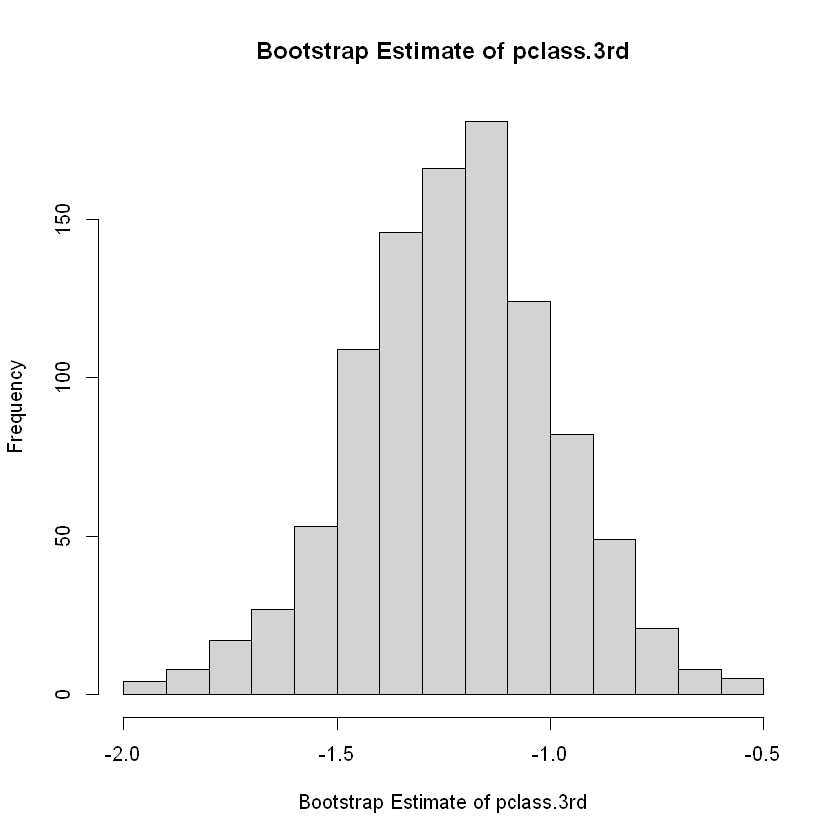

In [99]:
hist(titanic.logmod.boot.pclass.3rd,xlab="Bootstrap Estimate of pclass.3rd",main="Bootstrap Estimate of pclass.3rd")

In [100]:
quantile(titanic.logmod.boot.pclass.3rd,probs=seq(0.025,0.975,0.95))

2.5%      97.5% 
-1.7186274 -0.7813603

These bootstrap estimates' confidence intervals are quite similar with above result.

### 3. Explore the dataset as you like and report some of your findings.

Use LDA model to explore this dataset

In [84]:
library(MASS);

titanic.lda.mod =lda(Survived~Sex+Pclass+Age+SibSp+Fare+Parch,data=titanic.data)

titanic.lda.mod

Call:
lda(Survived ~ Sex + Pclass + Age + SibSp + Fare + Parch, data = titanic.data)

Prior probabilities of groups:
        0         1 
0.5938375 0.4061625 

Group means:
    Sexmale   Pclass      Age     SibSp     Fare     Parch
0 0.8490566 2.485849 30.62618 0.5259434 22.96546 0.3655660
1 0.3206897 1.872414 28.34369 0.4931034 51.84321 0.5275862

Coefficients of linear discriminants:
                 LD1
Sexmale -2.026826826
Pclass  -0.804709910
Age     -0.027085304
SibSp   -0.221255390
Fare     0.001274598
Parch   -0.050270281

From Coefficients of linear discriminants, we can conclude that female have greater survived probability than male and passenagers with higher ticket class have greater survived probability. 

From group means, we can find that about 85% the died passenagers are male and 68% survived passenagers are female. The mean age of died and survived groups are quite same, since most of passenagers are younger people. Although the coefficient of Fare is not significant, but from groups mean, we can find the mean fare of survived passenagers are about 2.5 times greater than died groups.

## Problem 3: Predicting First-Year College Students’ GPA

Import data and library.

In [30]:
library(leaps,boot);

gpa.data = read.csv("FirstYearGPA.csv")

### 1. Use all variables to predict students’ first-year GPA, by best subset selection up to the size of 8. 
Report the 8 best linear models (best model for each model size k = 1,···,8) and plot the R-square versus model size. Which is the best model using adjusted R-square?

In [31]:
gpa.regfit=regsubsets(GPA~.,data=gpa.data,method="exhaustive",nbest=1,nvmax=8)
gpa.regfit.sum=summary(gpa.regfit)
gpa.regfit.sum

Subset selection object
Call: regsubsets.formula(GPA ~ ., data = gpa.data, method = "exhaustive", 
    nbest = 1, nvmax = 8)
9 Variables  (and intercept)
             Forced in Forced out
HSGPA            FALSE      FALSE
SATV             FALSE      FALSE
SATM             FALSE      FALSE
Male             FALSE      FALSE
HU               FALSE      FALSE
SS               FALSE      FALSE
FirstGen         FALSE      FALSE
White            FALSE      FALSE
CollegeBound     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         HSGPA SATV SATM Male HU  SS  FirstGen White CollegeBound
1  ( 1 ) "*"   " "  " "  " "  " " " " " "      " "   " "         
2  ( 1 ) "*"   " "  " "  " "  "*" " " " "      " "   " "         
3  ( 1 ) "*"   " "  " "  " "  "*" " " " "      "*"   " "         
4  ( 1 ) "*"   "*"  " "  " "  "*" " " " "      "*"   " "         
5  ( 1 ) "*"   "*"  " "  " "  "*" "*" " "      "*"   " "         
6  ( 1 ) "*"   "*"  " "  "*"  "*" "*" " "      

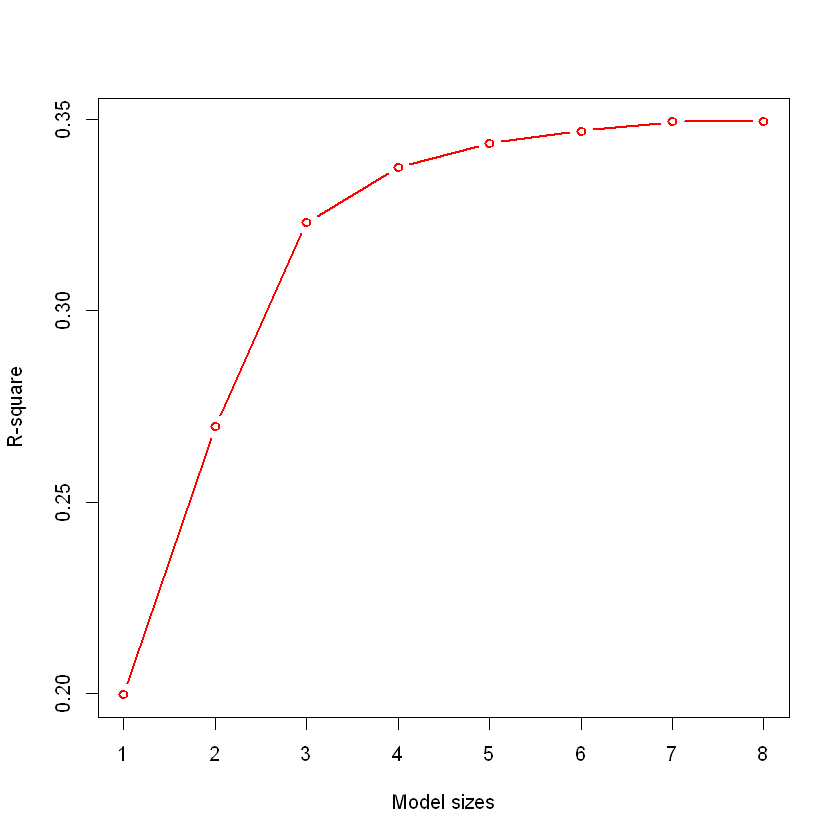

In [10]:
plot(1:8,gpa.regfit.sum$rsq,type="b",col="red",lwd=2,xlab="Model sizes",ylab="R-square")

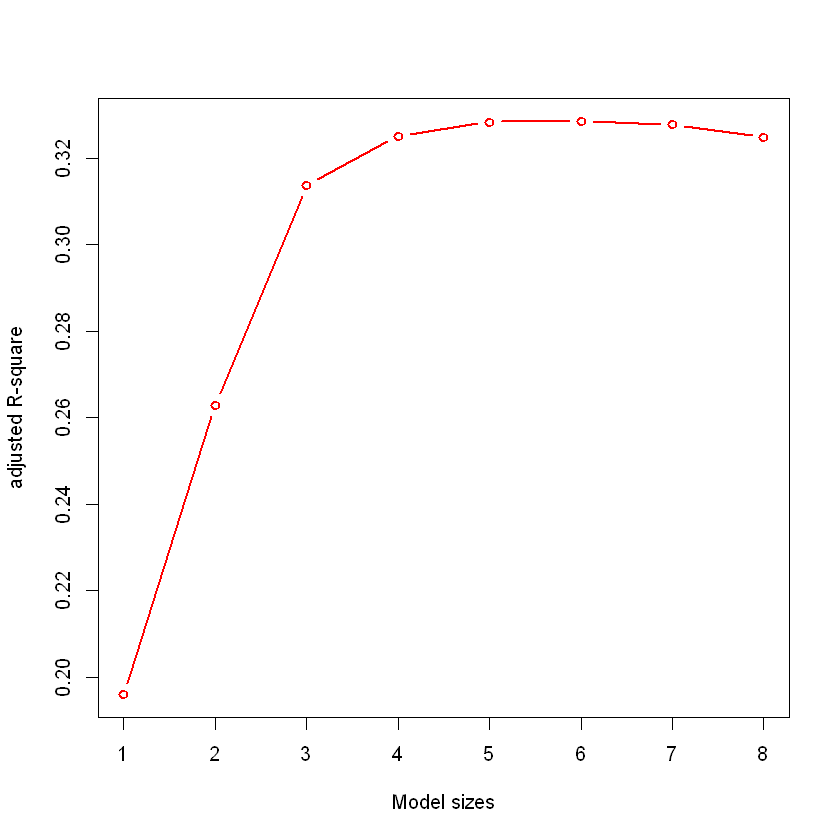

In [12]:
plot(1:8,gpa.regfit.sum$adjr2,type="b",col="red",lwd=2,xlab="Model sizes",ylab="adjusted R-square")

In [22]:
gpa.regfit.sum$adjr2

[1] 0.1960203 0.2629543 0.3136440 0.3251153 0.3283423 0.3285134 0.3278000
[8] 0.3247430

In [20]:
which.max(gpa.regfit.sum$adjr2)

[1] 6

From the plot of the adjusted R-square versus model size, we can see that the linear model with 6 predictors has the largest adjusted R-square, thus we choose the linear model with 6 predictors(GPA\~HSGPA+SATV+Male+HU+SS+White) as the best model. However, noticed that the adjusted R-square of the linear model with 5 predictors has no significant difference with the linear model with 6 predictors, thus we can also choose the linear model with 5 predictors(GPA\~HSGPA+SATV+HU+SS+White) as the best model of this sub-problem.

### 2. Repeat Step 1 but choose the best model by 5-fold CV. Report the summary of that model.

In [53]:
set.seed(114514)

gpa.regfit=regsubsets(GPA~.,data=gpa.data,method="exhaustive",nbest=1,nvmax=8)
gpa.regfit.sum=summary(gpa.regfit)

CV5.err=rep(0,8)
for(p in 1:8){
    dfname=c("GPA",names(gpa.data)[as.numeric(which(gpa.regfit.sum$which[p,]))[-1]])
    gpa.data.part=gpa.data[,dfname]
    glm.fit=glm(GPA~.,data=gpa.data.part)
    cv.err=cv.glm(gpa.data.part,glm.fit,K=5)
    CV5.err[p]=cv.err$delta[1] 
}

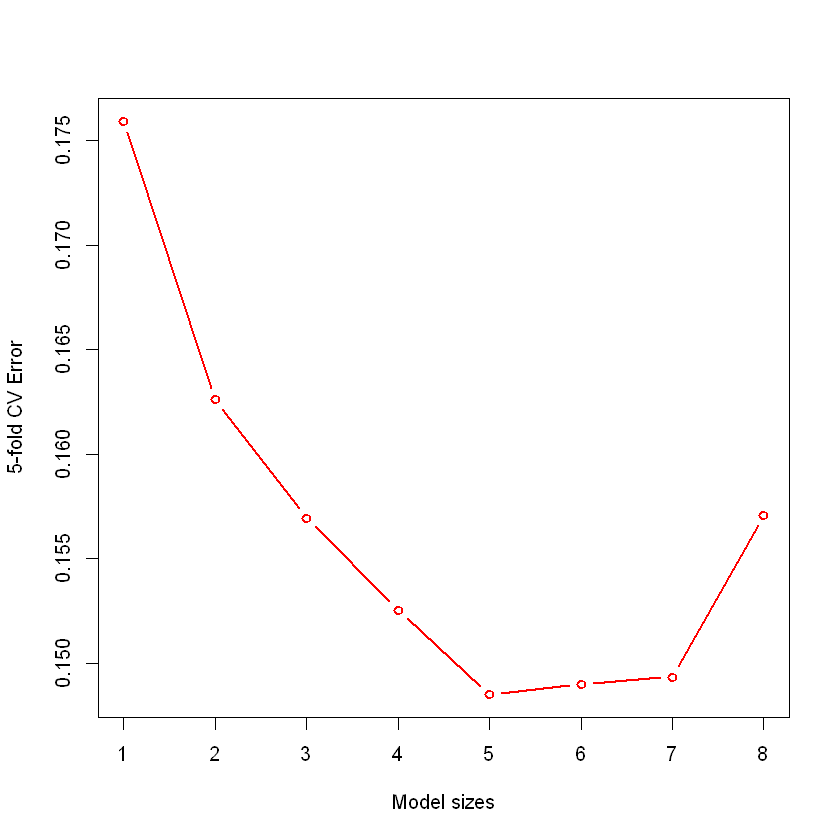

In [54]:
plot(1:8,CV5.err,type="b",col="red",lwd=2,xlab="Model sizes",ylab="5-fold CV Error")

From this plot of the 5-fold CV Error versus model sizes, we can see the model with 5 predictors has the smallest CV Error, thus we choose it as this best model in the sub-problem.

#### The summary of the best model in this sub-problem.

In [64]:
dfname=c("GPA",names(gpa.data)[as.numeric(which(gpa.regfit.sum$which[5,]))[-1]])
gpa.data.part=gpa.data[,dfname]
best.mod.fit=lm(GPA~.,data=gpa.data.part)
summary(best.mod.fit)


Call:
lm(formula = GPA ~ ., data = gpa.data.part)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.08660 -0.25827  0.04326  0.25822  0.87954 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.5684876  0.2827454   2.011  0.04563 *  
HSGPA       0.4739983  0.0709413   6.682 2.03e-10 ***
SATV        0.0007481  0.0003410   2.194  0.02932 *  
HU          0.0167447  0.0038183   4.385 1.82e-05 ***
SS          0.0077474  0.0054401   1.424  0.15587    
White       0.2060408  0.0685881   3.004  0.00298 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3815 on 213 degrees of freedom
Multiple R-squared:  0.3437,	Adjusted R-squared:  0.3283 
F-statistic: 22.31 on 5 and 213 DF,  p-value: < 2.2e-16


### 3. Use all variables to predict students’ first-year GPA, by forward stepwise selection up to the size of 8. 
Report the 8 (best model for each model size k = 1,···,8) best linear models and plot the adjusted R-square versus
model size. Which is the best model using BIC?

In [27]:
gpa.regfit=regsubsets(GPA~.,data=gpa.data,method="forward",nvmax=8)
gpa.regfit.sum=summary(gpa.regfit)
gpa.regfit.sum

Subset selection object
Call: regsubsets.formula(GPA ~ ., data = gpa.data, method = "forward", 
    nvmax = 8)
9 Variables  (and intercept)
             Forced in Forced out
HSGPA            FALSE      FALSE
SATV             FALSE      FALSE
SATM             FALSE      FALSE
Male             FALSE      FALSE
HU               FALSE      FALSE
SS               FALSE      FALSE
FirstGen         FALSE      FALSE
White            FALSE      FALSE
CollegeBound     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward
         HSGPA SATV SATM Male HU  SS  FirstGen White CollegeBound
1  ( 1 ) "*"   " "  " "  " "  " " " " " "      " "   " "         
2  ( 1 ) "*"   " "  " "  " "  "*" " " " "      " "   " "         
3  ( 1 ) "*"   " "  " "  " "  "*" " " " "      "*"   " "         
4  ( 1 ) "*"   "*"  " "  " "  "*" " " " "      "*"   " "         
5  ( 1 ) "*"   "*"  " "  " "  "*" "*" " "      "*"   " "         
6  ( 1 ) "*"   "*"  " "  "*"  "*" "*" " "      "*"   " "        

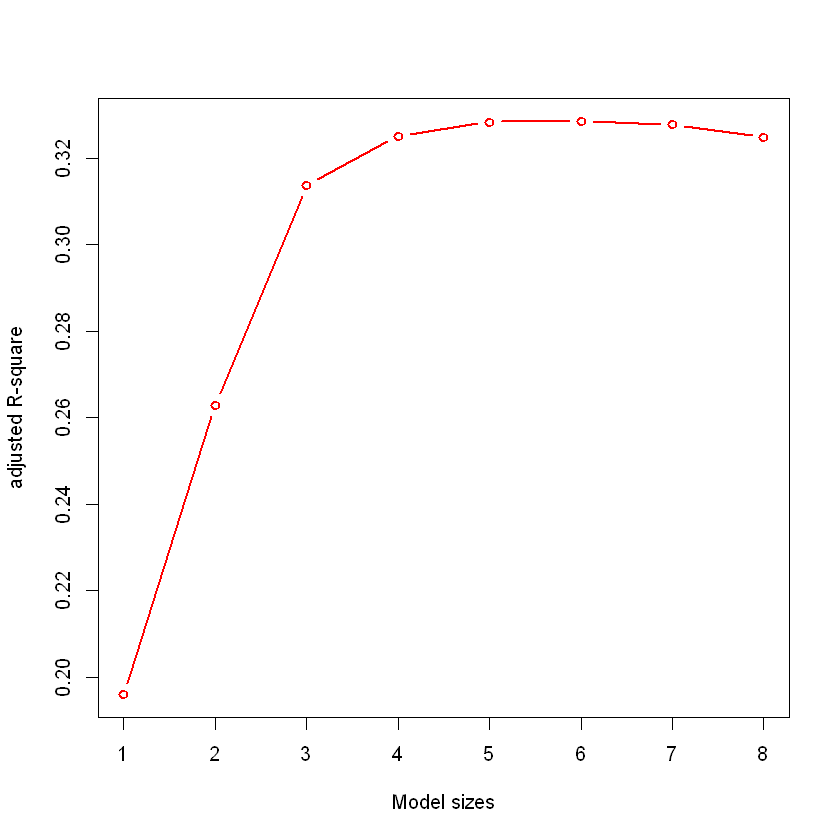

In [25]:
plot(1:8,gpa.regfit.sum$adjr2,type="b",col="red",lwd=2,xlab="Model sizes",ylab="adjusted R-square")

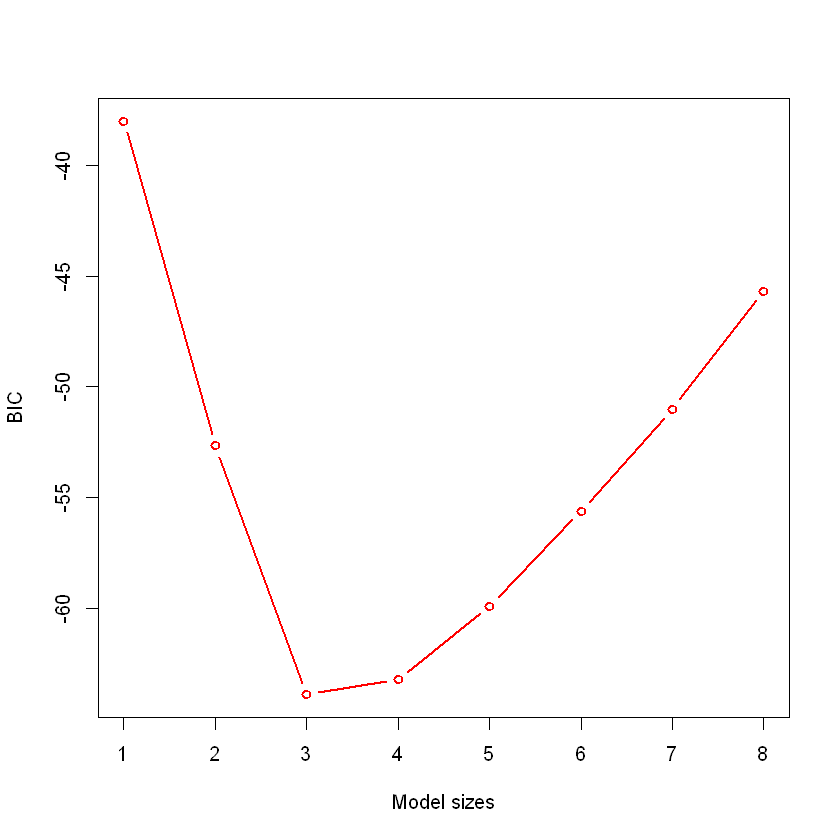

In [28]:
plot(1:8,gpa.regfit.sum$bic,type="b",col="red",lwd=2,xlab="Model sizes",ylab="BIC")

From the plot of the BIC versus model size, we can see that the linear model with 3 predictors has the smallest BIC, thus we choose the linear model with 3 predictors(GPA\~HSGPA+HU+White) as the best model. 

### 4. Repeat Step 3 but choose the best model by 5-fold CV. Report the summary of that model.

In [66]:
set.seed(114514)

gpa.regfit=regsubsets(GPA~.,data=gpa.data,method="forward",nvmax=8)
gpa.regfit.sum=summary(gpa.regfit)

CV5.err=rep(0,8)
for(p in 1:8){
    dfname=c("GPA",names(gpa.data)[as.numeric(which(gpa.regfit.sum$which[p,]))[-1]])
    gpa.data.part=gpa.data[,dfname]
    glm.fit=glm(GPA~.,data=gpa.data.part)
    cv.err=cv.glm(gpa.data.part,glm.fit,K=5)
    CV5.err[p]=cv.err$delta[1] 
}

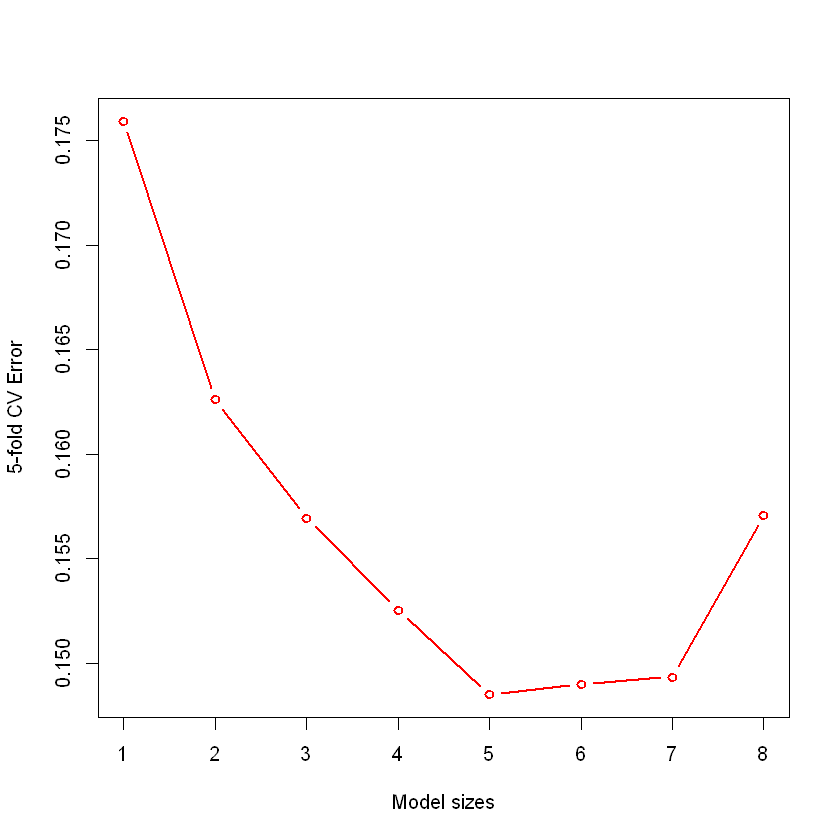

In [67]:
plot(1:8,CV5.err,type="b",col="red",lwd=2,xlab="Model sizes",ylab="5-fold CV Error")

From this plot of the 5-fold CV Error versus model sizes, we can see the model with 5 predictors has the smallest CV Error, thus we choose it as this best model in the sub-problem.

#### The summary of the best model in this sub-problem.

In [68]:
dfname=c("GPA",names(gpa.data)[as.numeric(which(gpa.regfit.sum$which[5,]))[-1]])
gpa.data.part=gpa.data[,dfname]
best.mod.fit=lm(GPA~.,data=gpa.data.part)
summary(best.mod.fit)


Call:
lm(formula = GPA ~ ., data = gpa.data.part)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.08660 -0.25827  0.04326  0.25822  0.87954 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.5684876  0.2827454   2.011  0.04563 *  
HSGPA       0.4739983  0.0709413   6.682 2.03e-10 ***
SATV        0.0007481  0.0003410   2.194  0.02932 *  
HU          0.0167447  0.0038183   4.385 1.82e-05 ***
SS          0.0077474  0.0054401   1.424  0.15587    
White       0.2060408  0.0685881   3.004  0.00298 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3815 on 213 degrees of freedom
Multiple R-squared:  0.3437,	Adjusted R-squared:  0.3283 
F-statistic: 22.31 on 5 and 213 DF,  p-value: < 2.2e-16


## Problem 4: Prediction of the Progression of Diabetes

First of all, load trainning and test data and import used library.

In [2]:
library(glmnet);

diab.data.train=read.csv("diabetes_train.csv")
diab.data.test=read.csv("diabetes_test.csv")

Notice that there are some features are originally coded by number 1 and 2, but they are replicated, so we drop these features coded by number 1 and 2.

In [3]:
diab.data.train=subset(diab.data.train,select=-c(age.1,sex.1,bmi.1,map.1,tc.1,ldl.1,hdl.1,tch.1,ltg.1,glu.1,age.2,bmi.2,map.2,tc.2,ldl.2,hdl.2,tch.2,ltg.2,glu.2))
diab.data.test=subset(diab.data.test,select=-c(age.1,sex.1,bmi.1,map.1,tc.1,ldl.1,hdl.1,tch.1,ltg.1,glu.1,age.2,bmi.2,map.2,tc.2,ldl.2,hdl.2,tch.2,ltg.2,glu.2))

Since notice that all the input features are already standardized, then I don't have to standardize them on my own.

### 1. Use the train dataset to fit LASSO estimators 
with regularization parameter λ chosen from the grid $10^{seq(4,−2,length=100)}$. Plot the coefficients versus the $l_1$ norm. Report any findings you think interesting.

In [4]:
grid=10^seq(4,-2,length=100)
x=model.matrix(Y~.,diab.data.train)[,-1]
y=diab.data.train$Y

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


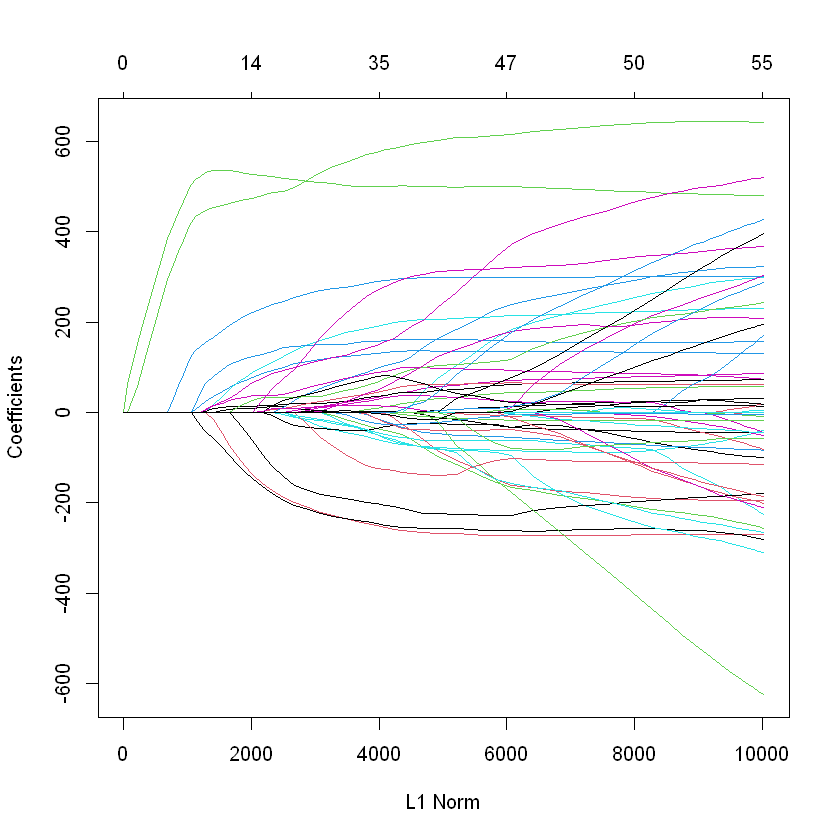

In [42]:
lasso.mod=glmnet(x,y,alpha=1,lambda=grid)
plot(lasso.mod)

Any interested finding?

In [63]:
lasso.mod$beta[1:30,40:59]

   [[ suppressing 20 column names 's39', 's40', 's41' ... ]]



30 x 20 sparse Matrix of class "dgCMatrix"
                                                                       
age      .         .         .        .        .        .        .     
sex      .         .         .        .        .        .        .     
bmi     61.19573 153.30136 224.0172 285.5201 339.0122 385.5369 416.6300
map      .         .         .        .        .        .       31.2602
tc       .         .         .        .        .        .        .     
ldl      .         .         .        .        .        .        .     
hdl      .         .         .        .        .        .        .     
tch      .         .         .        .        .        .        .     
ltg      .        57.55162 129.8938 192.8142 247.5392 295.1362 328.2691
glu      .         .         .        .        .        .        .     
age.sex  .         .         .        .        .        .        .     
age.bmi  .         .         .        .        .        .        .     
age.map  .         . 

#### Some interesting finding

From the plot the coefficients versus the $l_1$ norm and the coefficient of different lambda, we can find that bmi and ltg play the most significant role in this model. We know bmi is "body mass index", so this model show the truth that the fat person has the greater probability to have this disease and the progression of diabetes.

Meanwhile, we find that the influence of most of interaction of baseline variables is less than original baseline variables, which means if we want simple model we can just drop this interaction term in the model.

### 2. Use train dataset to fit LASSO and apply 10-fold cross validation. 
Plot the CV error versus the values of lambda. What is the best lambda value according CV error? Report the linear model using the best lambda
value, how many variables are included in the model, what are they?

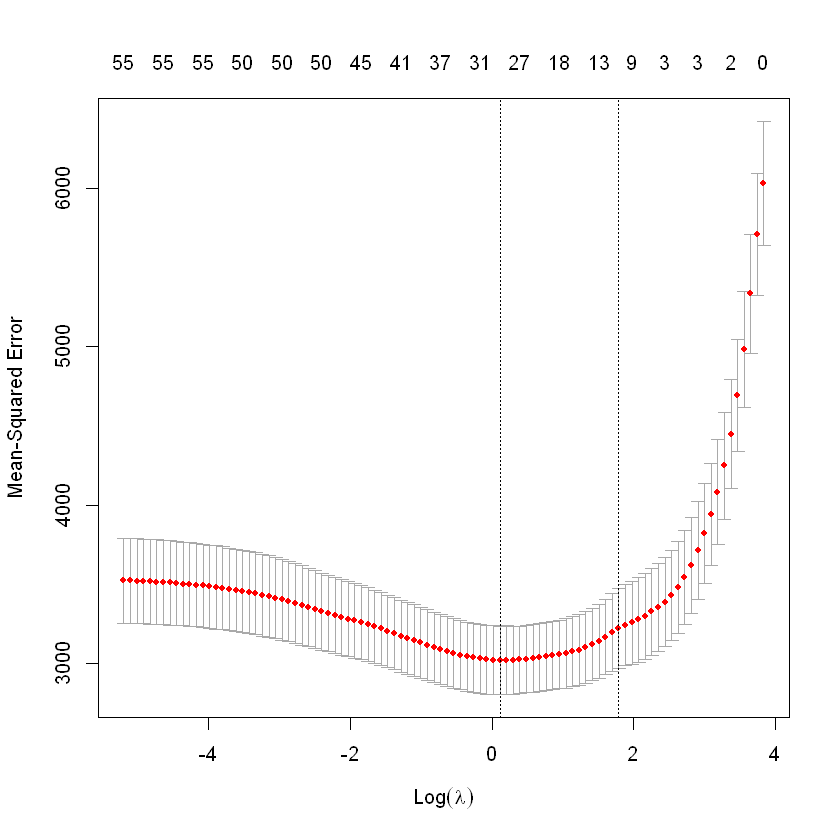

In [6]:
set.seed(114514)

cv.lasso=cv.glmnet(x,y,alpha=1,nfolds=10)
plot(cv.lasso)

In [26]:
# the best lambda value according CV error
best.lambda=cv.lasso$lambda.min
best.lambda

[1] 1.119385

The best lambda value according CV error is printed above.

In [29]:
cv.lasso.coef=predict(cv.lasso,type="coefficients",s=best.lambda)[1:56,]
cv.lasso.coef=cv.lasso.coef[cv.lasso.coef!=0]
# the coefficients of the best linear model using the best lambda value
cv.lasso.coef
# how many variables are included in the mode？
length(cv.lasso.coef)-1
# what are they？
names(cv.lasso.coef)[-1]

(Intercept)         sex         bmi         map          tc         hdl 
 150.690416 -230.054228  505.905228  274.584333  -38.704657 -229.937475 
        ltg         glu     age.sex     age.bmi     age.ldl     age.hdl 
 545.952933  121.785791  170.530278   18.983796   -9.076504   66.696220 
    age.ltg     age.glu     sex.bmi     sex.ldl     sex.hdl     bmi.map 
  70.141569   22.040673   29.571143  -25.448073   14.735423  149.974827 
     bmi.tc     bmi.hdl     bmi.ltg     map.ldl     map.hdl      tc.hdl 
 -14.733721  -38.455770   43.681097   15.511554   56.854118   15.129331 
     tc.tch      tc.ltg     ldl.ltg     ldl.glu     tch.ltg     tch.glu 
-186.535951  -78.504019  199.144963    2.881469  -22.121790  122.452289

[1] 29

[1] "sex"     "bmi"     "map"     "tc"      "hdl"     "ltg"     "glu"    
 [8] "age.sex" "age.bmi" "age.ldl" "age.hdl" "age.ltg" "age.glu" "sex.bmi"
[15] "sex.ldl" "sex.hdl" "bmi.map" "bmi.tc"  "bmi.hdl" "bmi.ltg" "map.ldl"
[22] "map.hdl" "tc.hdl"  "tc.tch"  "tc.ltg"  "ldl.ltg" "ldl.glu" "tch.ltg"
[29] "tch.glu"

### 3. Use the best model in Step 2 to predict the progression of diabetes on the test dataset, and report the mean test error.

In [28]:
x.test=model.matrix(Y~.,diab.data.test)[,-1]
y.gt=diab.data.test$Y

y.pred=predict(cv.lasso,s=best.lambda,newx=x.test)
mean((y.pred-y.gt)^2)

[1] 3049.855

The mean test error is printed above.